# Modèles de ML sur les données issues des requêtes

In [101]:
# librairies 
#----------------------------------------------
import pandas as pd
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt #to plot graphs
import matplotlib.patches as mpatches #to customize legend
import seaborn as sns #to plot graphs
import math 
import re #to find integers & floats in a string 
from collections import Counter #to count values in a dataframe or array
from datetime import date, timedelta, datetime #for the date
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [80]:
descriptive_analysis=True

### Récupération & mise en forme des datasets

In [81]:
# Lecture du fichier des données tests
#----------------------------------------------
PATH = '.' #modifier si besoin le chemin du fichier

# récupération du fichier contentant l'ensemble des données issues des requêtes
pricing_requests = pd.read_csv(PATH + '//pricing_requests_done.csv')

# récupération du fichier contenant les features des hotels
hotels = pd.read_csv('features_hotels.csv', index_col=['hotel_id', 'city'])

pricing_requests.head()

,hotel_id,price,stock,city,date,language,mobile,avatar_id,request_number
0,105,144,102,amsterdam,39,austrian,1,6056,1.0
1,880,113,81,amsterdam,39,austrian,1,6056,1.0
2,588,172,108,amsterdam,39,austrian,1,6056,1.0
3,352,105,84,amsterdam,39,austrian,1,6056,1.0
4,925,103,83,amsterdam,39,austrian,1,6056,1.0


In [82]:
# Obtenir des features en plus correspondant aux features de l'hotel : on fait une jointure 
#----------------------------------------------
pricing_requests = pricing_requests.join(hotels, on=['hotel_id', 'city'])
pricing_requests.head()

,hotel_id,price,stock,city,date,language,mobile,avatar_id,request_number,group,brand,parking,pool,children_policy
0,105,144,102,amsterdam,39,austrian,1,6056,1.0,Yin Yang,Ardisson,0,0,0
1,880,113,81,amsterdam,39,austrian,1,6056,1.0,Boss Western,Boss Western,0,0,0
2,588,172,108,amsterdam,39,austrian,1,6056,1.0,Independant,Independant,0,0,0
3,352,105,84,amsterdam,39,austrian,1,6056,1.0,Independant,Independant,1,0,0
4,925,103,83,amsterdam,39,austrian,1,6056,1.0,Boss Western,Boss Western,1,0,0


In [83]:
# Assigner le bon type aux variables
#----------------------------------------------
#--- Convert to integer: 
int_list = ["date","avatar_id","hotel_id","stock","request_number","price"] 
pricing_requests[int_list] = pricing_requests[int_list].astype(int) 
#--- Convert to categorical: 
pricing_requests["city"] = pd.Categorical(pricing_requests["city"],ordered=False)
pricing_requests["language"] = pd.Categorical(pricing_requests["language"],ordered=False)
pricing_requests["mobile"] = pd.Categorical(pricing_requests["mobile"],ordered=False)
pricing_requests["parking"] = pd.Categorical(pricing_requests["parking"],ordered=False)
pricing_requests["pool"] = pd.Categorical(pricing_requests["pool"],ordered=False)
pricing_requests["children_policy"] = pd.Categorical(pricing_requests["children_policy"],ordered=False)
pricing_requests["group"] = pd.Categorical(pricing_requests["group"],ordered=False)
pricing_requests["brand"] = pd.Categorical(pricing_requests["brand"],ordered=False)

In [39]:
# Vérification du type des variables
#----------------------------------------------
pricing_requests.dtypes

hotel_id              int32
price                 int32
stock                 int32
city               category
date                  int32
language           category
mobile             category
avatar_id             int32
request_number        int32
group              category
brand              category
parking            category
pool               category
children_policy    category
dtype: object

### Variables langues, city, brand

In [84]:
print("groupes d'hôtels:\n",np.unique(pricing_requests["group"]))
print()
print("brand des hôtels:\n",np.unique(pricing_requests["brand"]))

groupes d'hôtels:
 ['Accar Hotels' 'Boss Western' 'Chillton Worldwide' 'Independant'
 'Morriott International' 'Yin Yang']

brand des hôtels:
 ['8 Premium' 'Ardisson' 'Boss Western' 'Chill Garden Inn' 'Corlton'
 'CourtYord' 'Ibas' 'Independant' 'J.Halliday Inn' 'Marcure' 'Morriot'
 'Navatel' 'Quadrupletree' 'Royal Lotus' 'Safitel' 'Tripletree']


On remarque que "brand" est inclus dans "group". Pour une première analyse, une idée serait de ne garder que la variable "brand".

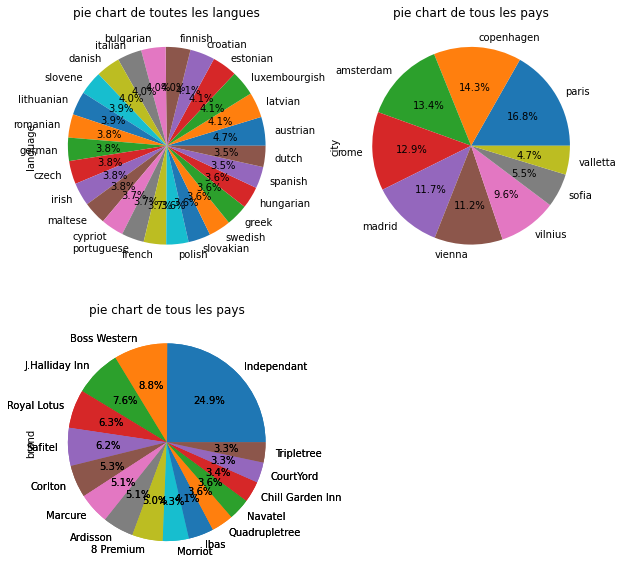

In [85]:
if descriptive_analysis: 
    plt.figure(figsize=(10,10))

    plt.subplot(2,2,1)
    pricing_requests['language'].value_counts().plot.pie( title="pie chart de toutes les langues", autopct='%1.1f%%')

    plt.subplot(2,2,2)
    pricing_requests['city'].value_counts().plot.pie( title="pie chart de tous les pays", autopct='%1.1f%%')


    plt.subplot(2,2,3)
    pricing_requests['brand'].value_counts().plot.pie( title="pie chart de toutes les brands", autopct='%1.1f%%')
    plt.subplot(2,2,3)
    pricing_requests['brand'].value_counts().plot.pie( title="pie chart de tous les pays", autopct='%1.1f%%')

###  Variable price

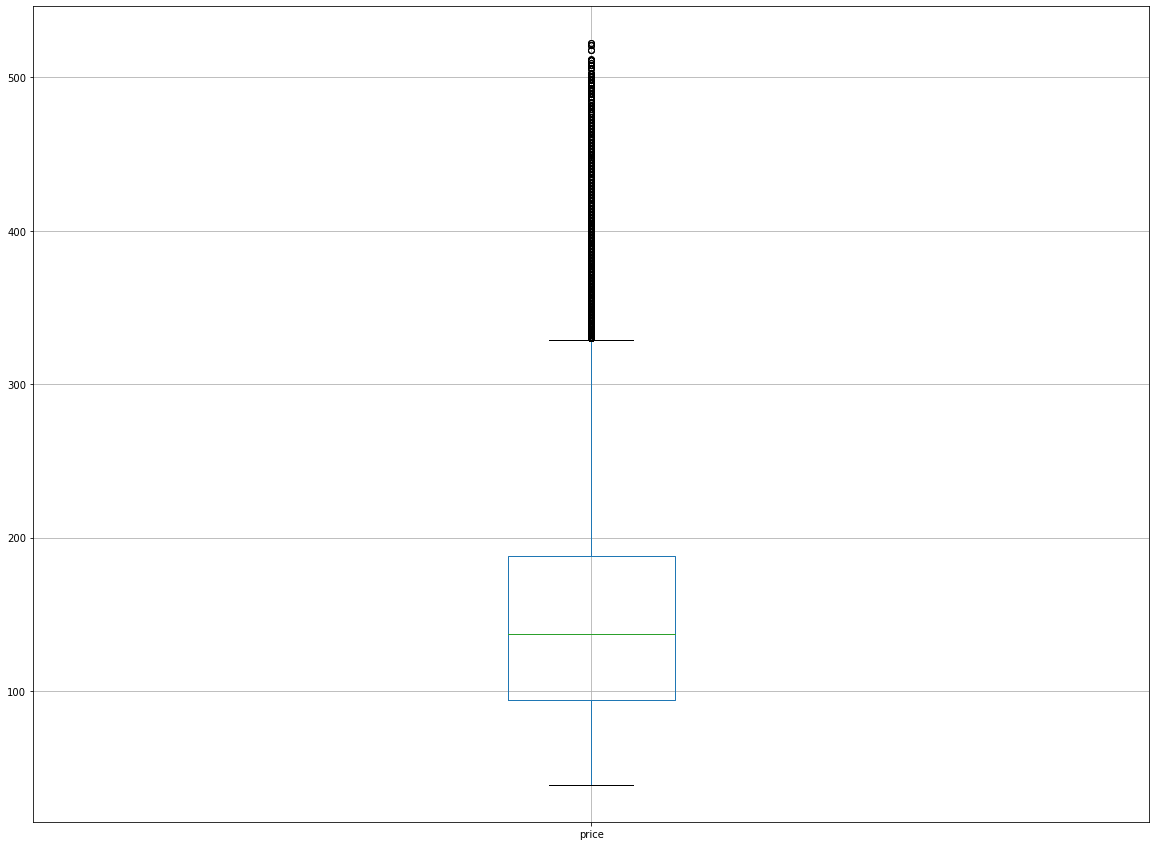

In [68]:
# Tracer la distribution des prix au lieu du boxplots (ou faire les 2)
fig2 = plt.figure(figsize=(20, 15))
boxplot = pricing_requests.boxplot(column=["price"])

Text(0.5, 1.0, 'price')

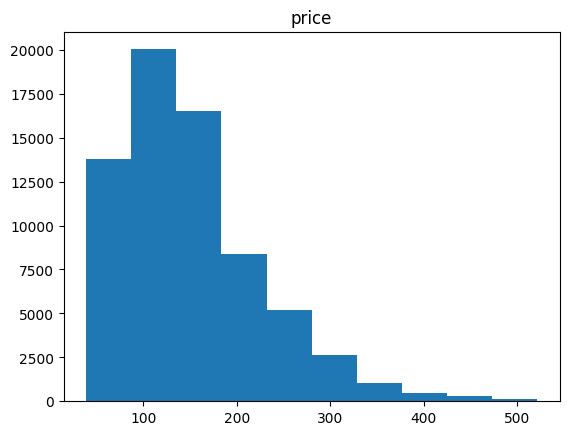

In [100]:
plt.hist(pricing_requests["price"])
plt.title("price")

### Variable date

In [86]:
def plotDates(data):
    """
    Cette fonction trace la répartition de la variable date
    """
    
    dates_requests = data[["request_number","date"]].drop_duplicates()
    
    fig, ax = plt.subplots(figsize=(20,8))

    counts, edges, bars = ax.hist(dates_requests.date,bins=len(dates_requests)//10, density=False,alpha = .5)

    ax.bar_label(bars,padding = 1,size = 12)
    ax.set_xticks(np.arange(0,41))
    ax.set_title("Nombre d'avatars par nombre de requêtes réalisées")
    ax.set_xlabel("valeur de date")
    ax.set_ylabel("nombre d'occurrences")

    ax.spines[['top','right','left']].set_visible(False)
    plt.show()

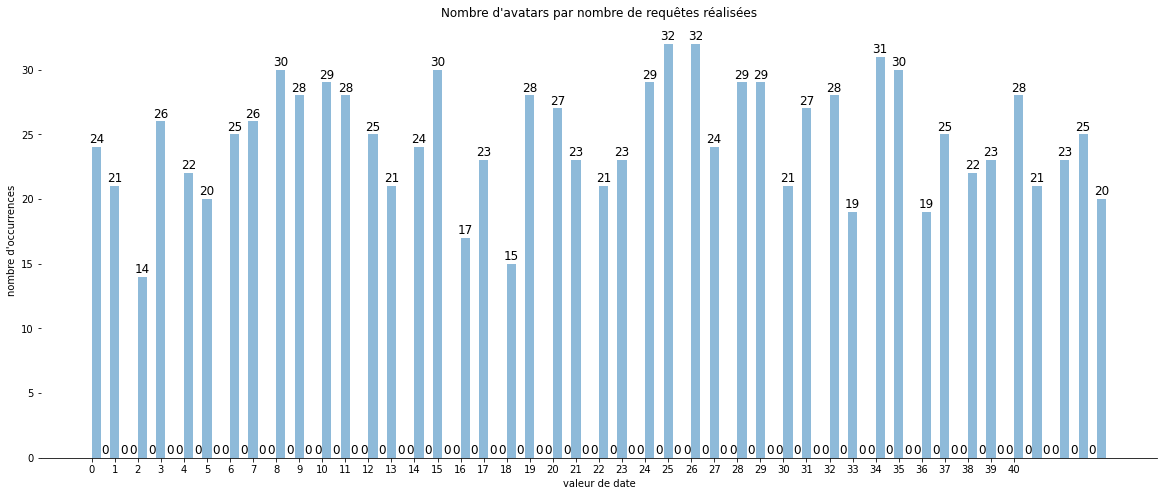

In [87]:
plotDates(pricing_requests)

### Transformation des données pour le ML

In [88]:
pricing_requests.dtypes

hotel_id              int32
price                 int32
stock                 int32
city               category
date                  int32
language           category
mobile             category
avatar_id             int32
request_number        int32
group              category
brand              category
parking            category
pool               category
children_policy    category
dtype: object

In [119]:
# Variables explicatives
#-------------------------------------------------
# Liste des variables categorical: 
cat_list1 = ["city", "language", "brand","mobile","parking","pool","children_policy"] #avec brand
cat_list2 = ["city", "language", "group","mobile","parking","pool","children_policy"] #avec group
cat_list3 = ["city", "language", "brand", "group","mobile","parking","pool","children_policy"] #avec brand & group

# Liste des variables quantitatives: 
quant_list1 = ["hotel_id", "stock","request_number", "date"] #on a enlevé avatar_id et price (=variable à expliquer)

# Création de la dataframe train
requests_pricingDum  = pd.get_dummies(pricing_requests[cat_list2],drop_first = True)
request_pricingQuant = pricing_requests[quant_list1]

dfC = pd.concat([requests_pricingDum,request_pricingQuant],axis=1)
dfC .columns

Index(['city_copenhagen', 'city_madrid', 'city_paris', 'city_rome',
       'city_sofia', 'city_valletta', 'city_vienna', 'city_vilnius',
       'language_bulgarian', 'language_croatian', 'language_cypriot',
       'language_czech', 'language_danish', 'language_dutch',
       'language_estonian', 'language_finnish', 'language_french',
       'language_german', 'language_greek', 'language_hungarian',
       'language_irish', 'language_italian', 'language_latvian',
       'language_lithuanian', 'language_luxembourgish', 'language_maltese',
       'language_polish', 'language_portuguese', 'language_romanian',
       'language_slovakian', 'language_slovene', 'language_spanish',
       'language_swedish', 'group_Boss Western', 'group_Chillton Worldwide',
       'group_Independant', 'group_Morriott International', 'group_Yin Yang',
       'mobile_1', 'parking_1', 'pool_1', 'children_policy_1',
       'children_policy_2', 'hotel_id', 'stock', 'request_number', 'date'],
      dtype='object')

In [98]:
# Variable à expliquer 
#-------------------------------------------------
Y = pricing_requests["price"]

In [99]:
# Construction de l'échantillon de test et de l'échantillon d'apprentissage
#-------------------------------------------------
X_train,X_test,Y_train,Y_test = train_test_split(dfC,Y,test_size=0.2,random_state=11)

In [114]:
# Standardisation des variables quantitatives 
#-------------------------------------------------
# standardisation
scaler = StandardScaler()
scaler.fit(X_train)
Xr_train = scaler.transform(X_train)
Xr_test = scaler.transform(X_test)

# transformation de Xr_train et Xr_test (numpy array) en dataframe
Xr_train = pd.DataFrame(Xr_train, index=X_train.index, columns=X_train.columns)
Xr_test  = pd.DataFrame(Xr_test, index=X_test.index, columns=X_test.columns)

### Algo 1: Gradient Boosting

In [118]:


params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, Y_train)
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)

KeyboardInterrupt: 

In [47]:
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(Y_price_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)

#plt.axvline((np.arange(params["n_estimators"]) + 1)[np.argmin(test_score)])
plt.axvline(200)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance/squared error loss")
fig.tight_layout()
plt.show()

NameError: name 'test_score' is not defined

In [47]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param=[{"learning_rate":[0.01]}]#optimisation de m
rf= GridSearchCV(GradientBoostingRegressor(n_estimators=200),
        param,cv=5,n_jobs=-1)
boostOpt=rf.fit(X_train, Y_price_train)

# paramètre optimal
print("Error la moins élevée = %f, Meilleur paramètre = %s" % (1. -boostOpt.best_score_,boostOpt.best_params_)) #1-R^2


KeyboardInterrupt: 

In [ ]:
 1-boostOpt.score(X_test, Y_price_test)

In [49]:
X_test.shape

(13709, 60)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# définition des paramètres
forest = RandomForestRegressor(n_estimators=500, 
    max_depth=None,
   min_samples_split=2, min_samples_leaf=1, 
   max_features='auto', max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# apprentissage
rfFitreg = forest.fit(X_train,Y_price_train) 
print("erreur out of bag", 1-rfFitreg.oob_score_) #on calcule l'erreur out of bag. 

In [ ]:
importances = rfFitreg.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(dfC.columns[indices[f]], importances[indices[f]])

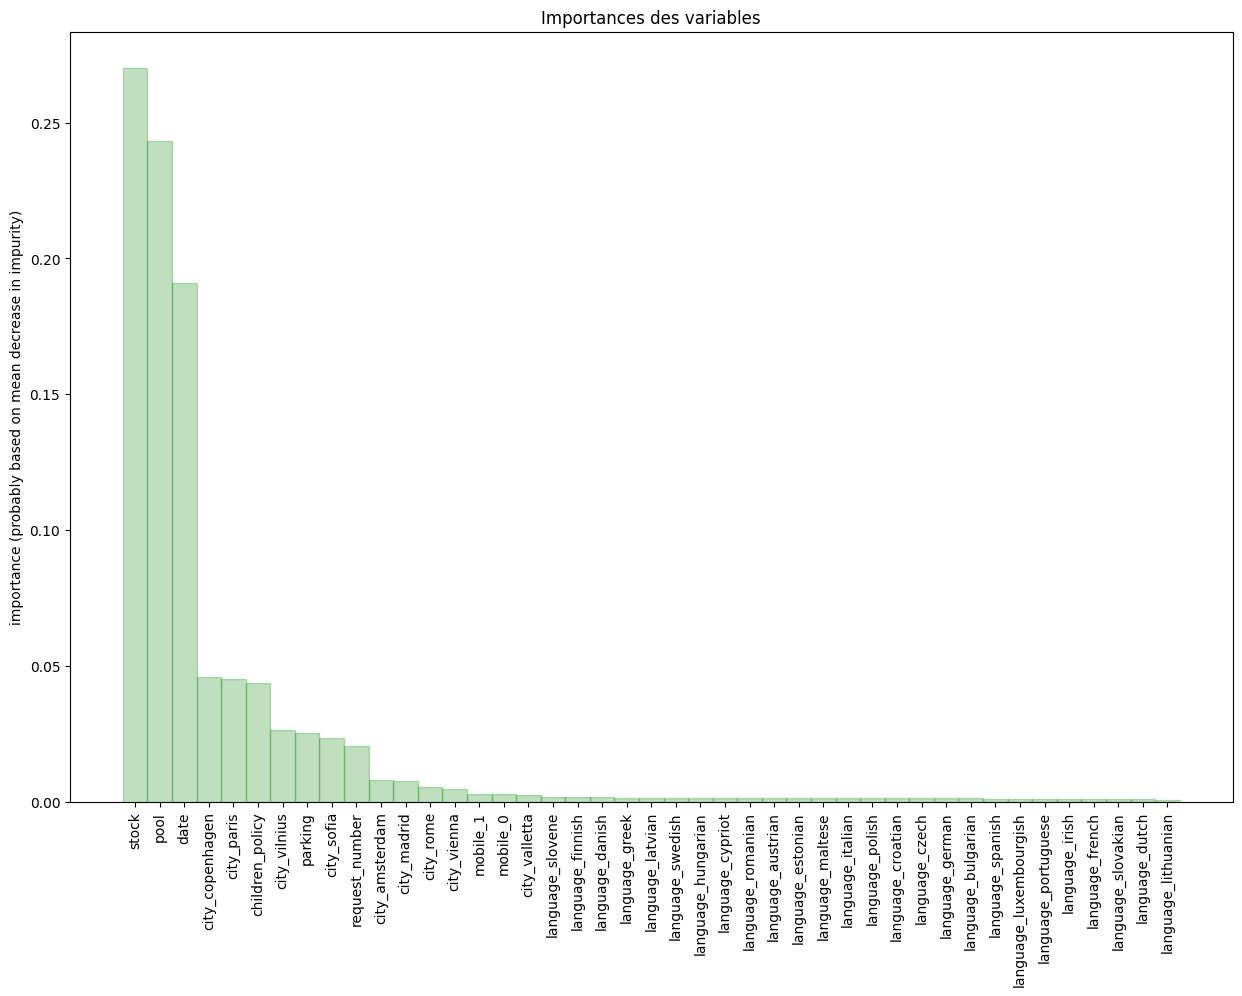

In [69]:


plt.figure(figsize=((15,10)))
plt.bar(list(dfC.columns[indices]), importances[indices],1, color='g', edgecolor="g", alpha=0.25)
plt.title("Importances des variables")
plt.ylabel("importance (probably based on mean decrease in impurity)")
plt.xticks(rotation=90)
plt.show()



In [62]:
 1-rfFitreg.score(X_test,Y_price_test)

0.05679773514931641